# MSM of the alanine dipeptide
Here we are going to test capabilities of the package to generate a consistent model from multiple files. 

The first thing one must do is download the data from the following [link](https://osf.io/a2vc7). Once this is done, we will import a number of libraries we will need as we run this example.

In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Discretizing the trajectory
We start loading the simulation data using the `trajectory` module. For this we use the external library [`MDtraj`](http://mdtraj.org), which contains all sorts of methods for parsing and calculating interestign properties of our time-series data.

In [2]:
import mdtraj as md
from mastermsm.trajectory import traj

In [10]:
trajs = traj.MultiTimeSeries(top='data/alaTB.gro', \
                    trajs=['data/alatb_n1_ppn24_part0.xtc', \
                           'data/alatb_n1_ppn24_part1.xtc', \
                           'data/alatb_n1_ppn24_part2.xtc', \
                             'data/alatb_n1_ppn24_part3.xtc'], stride=10)

In [11]:
phi_cum = []
psi_cum = []
for tr in trajs.traj_list:
    phi = md.compute_phi(tr.mdt)
    psi = md.compute_psi(tr.mdt)
    phi_cum.append(phi[1])
    psi_cum.append(psi[1])

Setting minimum cluster size to: 200
Setting min samples to: 200


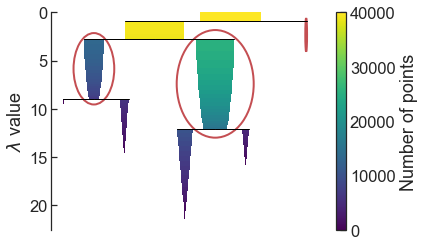

In [12]:
trajs.joint_discretize()

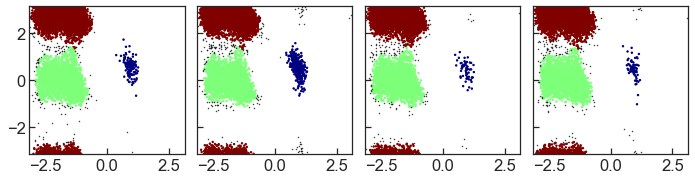

In [19]:
fig, ax = plt.subplots(1,4, figsize=(10,2.85), sharex=True, sharey=True)
ib = 0
ie = 0
for i in range(4):
    assign = np.array(trajs.traj_list[i].distraj) >=0
    ax[i].scatter(phi_cum[i][assign], psi_cum[i][assign], s=2, \
                  c=np.array(trajs.traj_list[i].distraj)[assign], cmap='jet')
    noise =  np.array(trajs.traj_list[i].distraj) ==-1
    ax[i].scatter(phi_cum[i][noise], psi_cum[i][noise], s=0.2, \
                  c='k')
ax[i].set_xlim(-np.pi, np.pi)
ax[i].set_ylim(-np.pi, np.pi)
plt.tight_layout(w_pad=0.5)

IndexError: list index out of range

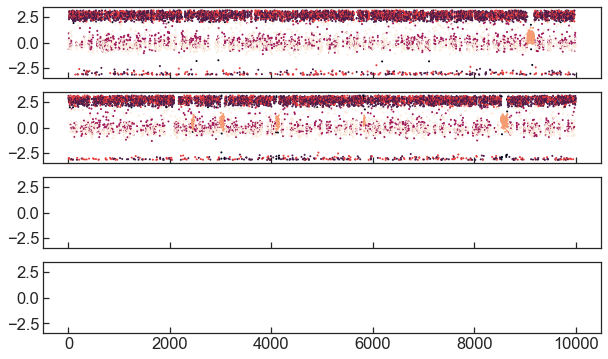

In [8]:
fig, ax = plt.subplots(4,1, figsize=(10,6), sharex=True, sharey=True)
ib = 0
ie = 0
for i in range(4):
    ie += len(trajs.traj_list[0].distraj)
    ax[i].scatter(range(len(phi_cum[ib:ie])), psi_cum[ib:ie], \
                        c=trajs.traj_list[i].distraj, s=1)
    ib = ie
plt.tight_layout(h_pad=0.5)

### Building the master equation model
After having loaded our trajectory using the functionalities from the `trajectory` module we start building the master equation model. For this, we make use of the `msm` module. There are two steps corresponding to the two main classes within that module. First we create an instance of the `SuperMSM`, which can be used to direct the whole process of constructing and validating the MSM.

In [8]:
[tr.find_keys() for tr in trajs.traj_list]
[tr.keys for tr in trajs.traj_list]

[[1, 3, 2, 0], [3, 1, 0, 2], [2, 3, 1, 0], [3, 1, 0]]

In [9]:
from mastermsm.msm import msm
msm_alaTB = msm.SuperMSM([tr for tr in trajs.traj_list])


 Building MSM from 
 ['send-david/data/out/4_1.xtc', 'send-david/data/out/4_2.xtc', 'send-david/data/out/4_3.xtc', 'send-david/data/out/4_4.xtc']
     # states: 4


Then, using the `do_msm` method, we produce instances of the `MSM` class at a desired lag time, $\Delta t$. Each of these contains an MSM built at a specific lag time. These are stored as a dictionary in the `msms` attribute of the `SuperMSM` class. 

In [10]:
lagt = 1
msm_alaTB.do_msm(lagt)
msm_alaTB.msms[lagt].do_trans()
msm_alaTB.msms[lagt].boots()

Text(0, 0.5, '$\\tau_i$')

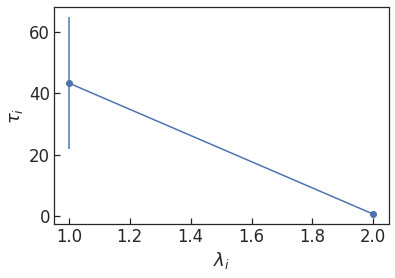

In [11]:
fig, ax = plt.subplots()
ax.errorbar(range(1,len(msm_alaTB.msms[1].peqT)-1), \
             msm_alaTB.msms[1].tau_ave, \
            msm_alaTB.msms[1].tau_std, fmt='o-')
ax.set_xlabel(r'$\lambda_i$')
ax.set_ylabel(r'$\tau_i$')

Text(0, 0.5, 'P$_\\mathrm{eq}$')

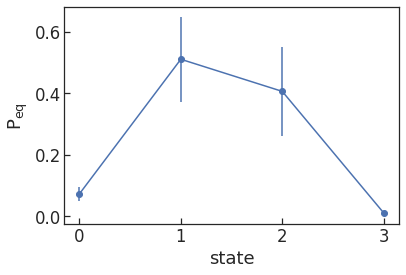

In [12]:
fig, ax = plt.subplots()
ax.errorbar(range(len(msm_alaTB.msms[1].peqT)), msm_alaTB.msms[1].peqT, \
             msm_alaTB.msms[1].peq_std, fmt='o-')
ax.set_xlabel('state')
ax.set_ylabel(r'P$_\mathrm{eq}$')